In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [2]:
import string
def strip_punctuation(s):
  return s.translate(str.maketrans({key: " " for key in string.punctuation}))

In [46]:
lines = []
for part in ("00000", "00001"):
  with open("../output/2017-01-03_13.57.34/part-%s" % part) as f:
    lines += f.readlines()

df = pd.read_json('[%s]' % ','.join(lines))

# Create a new feature
df["has_qmark"] = df.Body.apply(lambda s: "?" in s)
df["num_qmarks"] = df.Body.apply(lambda s: s.count("?"))
df["body_length"] = df.Body.apply(lambda s: len(s))


# Filter for PostTypeId = {1, 2}
df = df.loc[df.PostTypeId.apply(lambda x: x in [1, 2]), :]

# Reindex
df = df.reindex()

df.head()

,Body,Id,PostTypeId,Score,Tags,has_qmark,num_qmarks,body_length
0,"What does ""backprop"" mean? I've Googled it, bu...",1,1,5,"[neural-networks, definitions]",True,2,179
1,Does increasing the noise in data help to impr...,2,1,7,[generalization],True,3,213
2,"""Backprop"" is the same as ""backpropagation"": i...",3,2,10,[],False,0,117
3,"When you're writing your algorithm, how do you...",4,1,16,"[deep-network, layers, neurons]",True,2,184
4,I have a LEGO Mindstorms EV3 and I'm wondering...,5,1,0,[mindstorms],True,2,333


In [ ]:
df = df.reindex

In [24]:
n_questions = np.sum(df.PostTypeId == 1)
n_answers = np.sum(df.PostTypeId == 2)
print("No. questions {0} / No. answers {1}".format(n_questions, n_answers))

No. questions 421 / No. answers 749


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

X = df.loc[:, ['num_qmarks', 'body_length']]
y = df.loc[:, 'PostTypeId']

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.3, random_state=42)

classifier = RandomForestClassifier()

classifier.fit(X_train, y_train)

print(classifier.score(X_train, y_train))
print(classifier.score(X_test, y_test))

classifier.feature_importances_

0.985347985348
0.868945868946


array([ 0.50264062,  0.49735938])

In [78]:
nltk.corpus.stopwords.stopwords("english")

LookupError: 
**********************************************************************
  Resource 'corpora/stopwords' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/Users/joshuaarnold/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
import nltk

class FSTransformer(BaseEstimator, TransformerMixin):
  """
  Returns the different feature names
  """
  def __init__(self, features):
    self.features = features
    pass

  def fit(self, X, y):
    return self
  
  def transform(self, df):
    return df[self.features].as_matrix()

  
class CountVecTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.vectorizer = CountVectorizer(binary=False)
    pass
  
  def fit(self, df, y):
    self.vectorizer.fit(df.Body)
    return self
  
  def transform(self, df):
    return self.vectorizer.transform(df.Body).todense()

In [141]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

model_pipe = Pipeline([
    ("features", 
      FeatureUnion([
        ("derived", FSTransformer(["has_qmark", "num_qmarks", "body_length"])),
        ("count_vec", CountVecTransformer())
      ])
     ),
    ("best_features", SelectKBest(chi2, k=10)),
    ("clf", RandomForestClassifier())
  ])

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

X = df
y = df.PostTypeId

for train_index, test_index in sss.split(X.as_matrix(), y.as_matrix()):
  X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  
  model_pipe.fit(X_train, y_train)
  J_train = model_pipe.score(X_train, y_train)
  J_test = model_pipe.score(X_test, y_test)
  y_pred = model_pipe.predict(X_test)
  f1 = f1_score(y_test, y_pred)
  print("J_train: {0} J_test: {1} f1: {2}".format(J_train, J_test, f1))

J_train: 0.9963369963369964 J_test: 0.905982905982906 f1: 0.8663967611336032
J_train: 0.989010989010989 J_test: 0.905982905982906 f1: 0.8641975308641975
J_train: 0.9938949938949939 J_test: 0.9031339031339032 f1: 0.864
J_train: 0.9963369963369964 J_test: 0.9202279202279202 f1: 0.8852459016393444
J_train: 0.9853479853479854 J_test: 0.9031339031339032 f1: 0.8671875
J_train: 0.9975579975579976 J_test: 0.886039886039886 f1: 0.83739837398374
J_train: 0.9951159951159951 J_test: 0.8831908831908832 f1: 0.825531914893617
J_train: 0.989010989010989 J_test: 0.9031339031339032 f1: 0.8671875
J_train: 0.9926739926739927 J_test: 0.9145299145299145 f1: 0.8790322580645162
J_train: 0.9853479853479854 J_test: 0.9088319088319088 f1: 0.8677685950413223


In [149]:
modelCV = GridSearchCV(model_pipe, {"best_features__k":[3 ** i for i in range(1,7)]})
modelCV.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('derived', FSTransformer(features=['has_qmark', 'num_qmarks', 'body_length'])), ('count_vec', CountVecTransformer())],
       transformer_weights=None)), ('best_features', SelectKBest(k=10, score_func=<function chi2 at 0x116225840>...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'best_features__k': [3, 9, 27, 81, 243, 729]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [150]:
def grid_score_to_df(modelCV):
  records = [{**score.parameters, **{"mean_validation_score": score.mean_validation_score}} 
             for score in modelCV.grid_scores_]
  return pd.DataFrame(records)

In [151]:
cv_accuracy = grid_score_to_df(modelCV)
cv_accuracy

,best_features__k,mean_validation_score
0,3,0.789744
1,9,0.896581
2,27,0.898291
3,81,0.904274
4,243,0.903419
5,729,0.903419


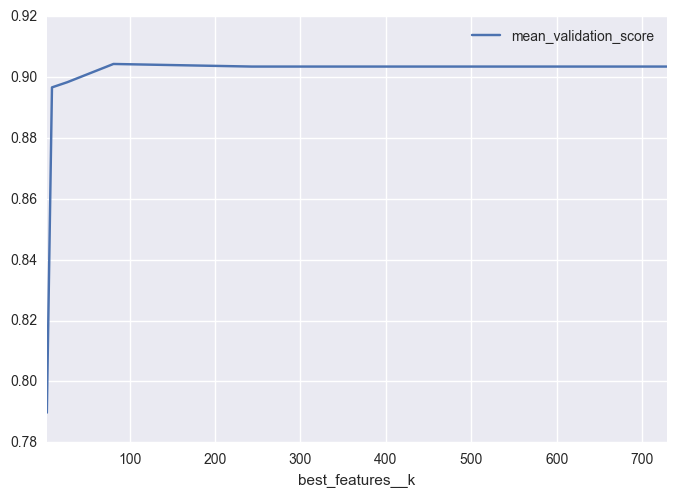

In [152]:
cv_accuracy.plot(x="best_features__k", y="mean_validation_score")